In [1]:
# Generic ones
import numpy as np
import pandas as pd
import os

# Word processing libraries
import re
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Widen the size of each cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import glob
import gzip

# dfs=[]
data = None
total_count=0
keywords_str='#chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu'
print('filtering by:', keywords_str)

for file in glob.glob("E:\\Projects\\twitter_covid\\2020-04\\*.gz"):
#     print(file)
    df = pd.read_json(path_or_buf=file, lines=True, compression='infer')
#     print('Read. Size: ', df.shape)
    
    total_count+=df.shape[0]
    df = df[df['full_text'].str.contains("(?i)"+keywords_str)]
    df.reset_index(inplace = True, drop = True)
    if data is None:
        data = df
    else:
        data = pd.concat([data, df], axis = 0)
        # Reset_index
        data.reset_index(inplace = True, drop = True)
        
data_orig=data.copy()

print('Size of dataset before filtering:', total_count)
print('Size of dataset after filtering:', data.shape[0])



filtering by: #chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu
Size of dataset before filtering: 1929310
Size of dataset after filtering: 2539


In [3]:
data['hashtags'] = data['entities'].apply(lambda x: x['hashtags'])
data['hashtags'].head(3)

0    [{'text': 'WuhanCoronaVirus', 'indices': [29, ...
1    [{'text': 'ChinaVirus19', 'indices': [122, 135]}]
2      [{'text': 'ChineseVirus', 'indices': [39, 52]}]
Name: hashtags, dtype: object

In [4]:
# Remove empty tweets
data.dropna(subset = ['full_text'], inplace = True)
# The unicode accounts for Chinese characters and punctuations.
def strip_chinese_words(string):
    # list of english words
    en_list = re.findall(u'[^\u4E00-\u9FA5\u3000-\u303F]', str(string))
    
    # Remove word from the list, if not english
    for c in string:
        if c not in en_list:
            string = string.replace(c, '')
    return string
# Apply strip_chinese_words(...) on the column 'text'
data['full_text'] = data['full_text'].apply(lambda x: strip_chinese_words(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_scope,withheld_copyright,withheld_in_countries,hashtags
0,2020-04-01 23:00:05+00:00,1245486119770296326,1245486119770296320,Why it deserves to be called #WuhanCoronaVirus...,False,"[0, 206]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'WuhanCoronaVirus', 'indices': [29, ..."
1,2020-04-01 23:00:25+00:00,1245486204025536512,1245486204025536512,"RT @VishalK20096764: Criminal Negligence,@UN,@...",False,"[0, 140]","{'hashtags': [{'text': 'ChinaVirus19', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,en,{'created_at': 'Wed Apr 01 22:59:54 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'ChinaVirus19', 'indices': [122, 135]}]"
2,2020-04-01 23:18:06+00:00,1245490654563704839,1245490654563704832,RT @ashok_jaswal: @MichaelCoudrey This #Chines...,False,"[0, 140]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,en,{'created_at': 'Wed Apr 01 08:09:20 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [39, 52]}]"
3,2020-04-01 23:18:20+00:00,1245490712784887808,1245490712784887808,RT @SidneyPowell1: They started the curve in t...,False,"[0, 139]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,en,{'created_at': 'Wed Apr 01 21:05:44 +0000 2020...,1.245321e+18,1.245321e+18,"{'url': 'https://t.co/2KhWFlZxIj', 'expanded':...",NaN,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [67, 80]}]"
4,2020-04-01 23:19:05+00:00,1245490898860826624,1245490898860826624,@WHO @DrTedros #wuhanvirus #wholiedpeopledied,False,"[15, 45]","{'hashtags': [{'text': 'wuhanvirus', 'indices'...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.245403e+18,...,und,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'wuhanvirus', 'indices': [15, 26]}, ..."


In [5]:
# Define function to sieve out @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames
# Create a new column and apply the function on the column 'text'
data['mentioned_users'] = data['full_text'].apply(lambda x: mentioned_users(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_scope,withheld_copyright,withheld_in_countries,hashtags,mentioned_users
0,2020-04-01 23:00:05+00:00,1245486119770296326,1245486119770296320,Why it deserves to be called #WuhanCoronaVirus...,False,"[0, 206]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'WuhanCoronaVirus', 'indices': [29, ...",[]
1,2020-04-01 23:00:25+00:00,1245486204025536512,1245486204025536512,"RT @VishalK20096764: Criminal Negligence,@UN,@...",False,"[0, 140]","{'hashtags': [{'text': 'ChinaVirus19', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,{'created_at': 'Wed Apr 01 22:59:54 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'ChinaVirus19', 'indices': [122, 135]}]","[@VishalK20096764:, @UN,@UNHumanRights]"
2,2020-04-01 23:18:06+00:00,1245490654563704839,1245490654563704832,RT @ashok_jaswal: @MichaelCoudrey This #Chines...,False,"[0, 140]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,{'created_at': 'Wed Apr 01 08:09:20 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [39, 52]}]","[@ashok_jaswal:, @MichaelCoudrey, @DrTedr…]"
3,2020-04-01 23:18:20+00:00,1245490712784887808,1245490712784887808,RT @SidneyPowell1: They started the curve in t...,False,"[0, 139]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,{'created_at': 'Wed Apr 01 21:05:44 +0000 2020...,1.245321e+18,1.245321e+18,"{'url': 'https://t.co/2KhWFlZxIj', 'expanded':...",NaN,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [67, 80]}]",[@SidneyPowell1:]
4,2020-04-01 23:19:05+00:00,1245490898860826624,1245490898860826624,@WHO @DrTedros #wuhanvirus #wholiedpeopledied,False,"[15, 45]","{'hashtags': [{'text': 'wuhanvirus', 'indices'...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.245403e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'wuhanvirus', 'indices': [15, 26]}, ...","[@WHO, @DrTedros]"


In [6]:
# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
# Define the function to implement POS tagging:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Define the main function to clean text in various ways:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. tokenise text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # 9. remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. pos tag text and lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # 11. remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)
# Apply function on the column 'text':
data['cleaned_text'] = data['full_text'].apply(lambda x: clean_text(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_scope,withheld_copyright,withheld_in_countries,hashtags,mentioned_users,cleaned_text
0,2020-04-01 23:00:05+00:00,1245486119770296326,1245486119770296320,Why it deserves to be called #WuhanCoronaVirus...,False,"[0, 206]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'WuhanCoronaVirus', 'indices': [29, ...",[],deserves call \nus intelligence community find...
1,2020-04-01 23:00:25+00:00,1245486204025536512,1245486204025536512,"RT @VishalK20096764: Criminal Negligence,@UN,@...",False,"[0, 140]","{'hashtags': [{'text': 'ChinaVirus19', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'ChinaVirus19', 'indices': [122, 135]}]","[@VishalK20096764:, @UN,@UNHumanRights]",rt criminal negligence way world deal chinese ...
2,2020-04-01 23:18:06+00:00,1245490654563704839,1245490654563704832,RT @ashok_jaswal: @MichaelCoudrey This #Chines...,False,"[0, 140]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [39, 52]}]","[@ashok_jaswal:, @MichaelCoudrey, @DrTedr…]",rt make china export every country help chines...
3,2020-04-01 23:18:20+00:00,1245490712784887808,1245490712784887808,RT @SidneyPowell1: They started the curve in t...,False,"[0, 139]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,1.245321e+18,1.245321e+18,"{'url': 'https://t.co/2KhWFlZxIj', 'expanded':...",NaN,NaN,NaN,NaN,"[{'text': 'ChineseVirus', 'indices': [67, 80]}]",[@SidneyPowell1:],rt start curve wrong place month many people a...
4,2020-04-01 23:19:05+00:00,1245490898860826624,1245490898860826624,@WHO @DrTedros #wuhanvirus #wholiedpeopledied,False,"[15, 45]","{'hashtags': [{'text': 'wuhanvirus', 'indices'...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.245403e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'text': 'wuhanvirus', 'indices': [15, 26]}, ...","[@WHO, @DrTedros]",


In [7]:
# Define a function to perform this extraction:
def extract_hashtags(hashtag_list):
    # argument:
    # hashtag_list - a list of dictionary(ies), each containing a hashtag
    
    # Create a list to store the hashtags
    hashtags = []
    if isinstance(hashtag_list, float):
        hashtag_list=[]
    
    # Loop through the list:
    for i in range(0, len(hashtag_list)):
        # extract the hashtag value using the key - 'text'
        # For our purposes, we can ignore the indices, which tell us the position of the hashtags in the string of tweet
        # lowercase the text as well
        hashtags.append(hashtag_list[i]['text'].lower())
        
    return hashtags
# Apply function on the column - data['hashtags']
data['hashtags'] = data['hashtags'].apply(lambda x: extract_hashtags(x))
# Check out the updated column 'hashtags'
print(data.head()['hashtags'])

0    [wuhancoronavirus, wuhanvirus, wednesdaywisdom]
1                                     [chinavirus19]
2                                     [chinesevirus]
3                                     [chinesevirus]
4                    [wuhanvirus, wholiedpeopledied]
Name: hashtags, dtype: object


In [8]:
#Show hashtags
        
data[data['hashtags'].apply(lambda x: True if len(x)>0 else False)]['hashtags']

0         [wuhancoronavirus, wuhanvirus, wednesdaywisdom]
1                                          [chinavirus19]
2                                          [chinesevirus]
3                                          [chinesevirus]
4                         [wuhanvirus, wholiedpeopledied]
                              ...                        
2534                                       [chinesevirus]
2535    [chinarisk, chinavirus, coronavirus, ccpvirus,...
2536    [suechina, ccpvirus, lawsuit, chinavirus, 罪魁禍首...
2537    [taiwancanhelp, covid19, chinaliedpeopledied, ...
2538    [chinavirus, chinaliedpeopledied, chinamustfal...
Name: hashtags, Length: 2537, dtype: object

In [9]:
data['location'] = df.user.apply(lambda x: x['location'])
data['acctdesc'] = df.user.apply(lambda x: x['description'])
data[['location','acctdesc']].head(3)

,location,acctdesc
0,,"""China is using coronavirus aid to whitewash i..."
1,India,"Interested in politics, sports."
2,,


In [10]:
# Replace NaN (empty) values with n.a to indicate that the user did not state his location
# Define a function to handle this:
def remove_nan(text):
    if pd.isnull(text) == True: # entry is NaN
        text = 'n.a'
    else:
        # lowercase text for possible easy handling
        text = text.lower()
        
    return text
# Apply function on column - data['location']
data['location'] = data['location'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['location'])
# Let's take a quick look at the value_counts()
data['location'].value_counts()

0                         
1                    india
2                         
3    seal beach (socal-oc)
4               texas, usa
Name: location, dtype: object


n.a                               2496
                                    13
india                                4
worldwide                            2
hong kong                            2
bandung, indonesia                   1
firenze, toscana                     1
jpn　recesses of a mountain           1
bengaluru south, india               1
campinas, brasil                     1
houston                              1
uan, thailand                        1
earth                                1
cochin, india                        1
uttar pradesh, india                 1
scotland                             1
varanasi                             1
kalbi atayurdunda bir türk 💙         1
united states                        1
sydney, new south wales              1
mumbai, india                        1
chennai                              1
भारत                                 1
united kingdom                       1
texas, usa                           1
seal beach (socal-oc)    

In [11]:
# Apply the function already defined above: remove_nan(...)
# Apply function on column - data['acctdesc']
data['acctdesc'] = data['acctdesc'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['acctdesc'])

0    "china is using coronavirus aid to whitewash i...
1                      interested in politics, sports.
2                                                     
3    law geek(jd)@evictatty,ret’d #leo(#oc-#ca),#ma...
4    love the life you live💕live the life you love🇺...
Name: acctdesc, dtype: object


In [12]:
# Importing VADER from NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Create a sid object called SentimentIntensityAnalyzer()
sid = SentimentIntensityAnalyzer()
# Apply polarity_score method of SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x))
# Keep only the compound scores under the column 'Sentiment'
data = pd.concat([data.drop(['sentiment'], axis = 1), data['sentiment'].apply(pd.Series)], axis = 1)

In [13]:
# New column: number of characters in 'review'
data['numchars'] = data['cleaned_text'].apply(lambda x: len(x))
# New column: number of words in 'review'
data['numwords'] = data['cleaned_text'].apply(lambda x: len(x.split(" ")))
# Check the new columns:
data.tail(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,mentioned_users,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords
2537,2020-04-30 07:59:44+00:00,1255768785044140032,1255768785044140032,So?\nWho cares?\n#TaiwanCanHelp\n#COVID19\n#Ch...,False,"[0, 123]","{'hashtags': [{'text': 'TaiwanCanHelp', 'indic...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,[],so?\nwho cares?\n\n\n \n\n\n,n.a,n.a,0.0,0.355,0.645,0.563,21,3
2538,2020-04-30 07:59:46+00:00,1255768796259704833,1255768796259704832,#chinavirus #chinaliedpeopledied #chinamustfal...,False,"[0, 248]","{'hashtags': [{'text': 'chinavirus', 'indices'...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,[],,n.a,n.a,0.0,0.000,0.000,0.000,0,1


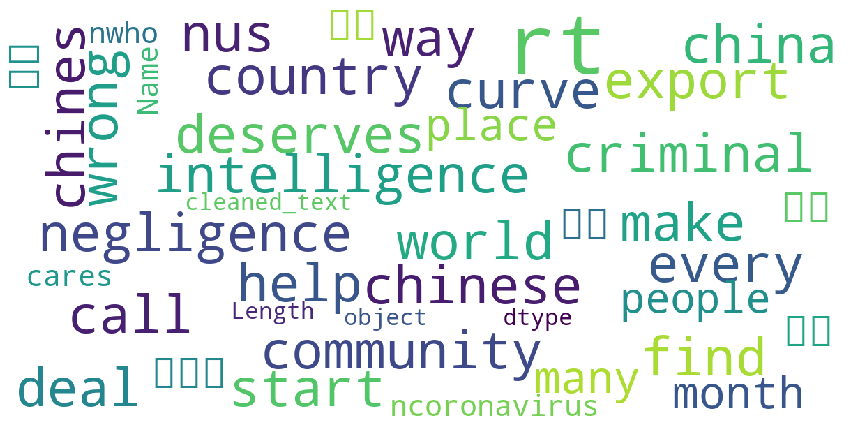

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['cleaned_text'])

In [15]:
# the column data['hashtags'] returns a list of string(s) for each tweet. Build a list of all hashtags in the dataset.
hashtag_list = []
for i in range(0, len(data)):
    # Obtain the current list of hashtags
    curr_hashtag = data.iloc[i, :]['hashtags']
    
    # Extract and append the hashtags to 'hashtag_list':
    for j in range(0, len(curr_hashtag)):
        hashtag_list.append(curr_hashtag[j])
        
# No. of hashtags
print('No. of hashtags used in {} tweets is {}'.format(len(data), len(hashtag_list)))

df_hashtag = pd.DataFrame(
    {'hashtags': hashtag_list}
)
print(df_hashtag.head(20))
print('Shape of df_hashtag is:', df_hashtag.shape)

No. of hashtags used in 2539 tweets is 7967
             hashtags
0    wuhancoronavirus
1          wuhanvirus
2     wednesdaywisdom
3        chinavirus19
4        chinesevirus
5        chinesevirus
6          wuhanvirus
7   wholiedpeopledied
8        chinesevirus
9          wuhanvirus
10           sakagibi
11          vaka15422
12           covidー19
13         chinavirus
14         chinavirus
15       chinesevirus
16                who
17           covid_19
18        cnnfakenews
19                cnn
Shape of df_hashtag is: (7967, 1)


                    hashtags  counts
285             chinesevirus    1048
250               chinavirus     868
1373              wuhanvirus     672
195                    china     328
402                  covid19     271
363              coronavirus     259
222      chinaliedpeopledied     214
181                 ccpvirus     130
286           chinesevirus19     122
428                 covid_19     101
173                      ccp      83
946                   nnevvy      64
1324                     who      57
221       chinaliedpeopledie      56
1350                   wuhan      54
231             chinamustpay      54
438                 covidー19      51
140             boycottchina      49
1356        wuhancoronavirus      48
219   chinaliedandpeopledied      47
270      chinesebioterrorism      46
289       chineseviruscorona      43
401                    covid      43
869             makechinapay      40
945                  nmslese      36
807                  kungflu      35
3

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32954 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from c

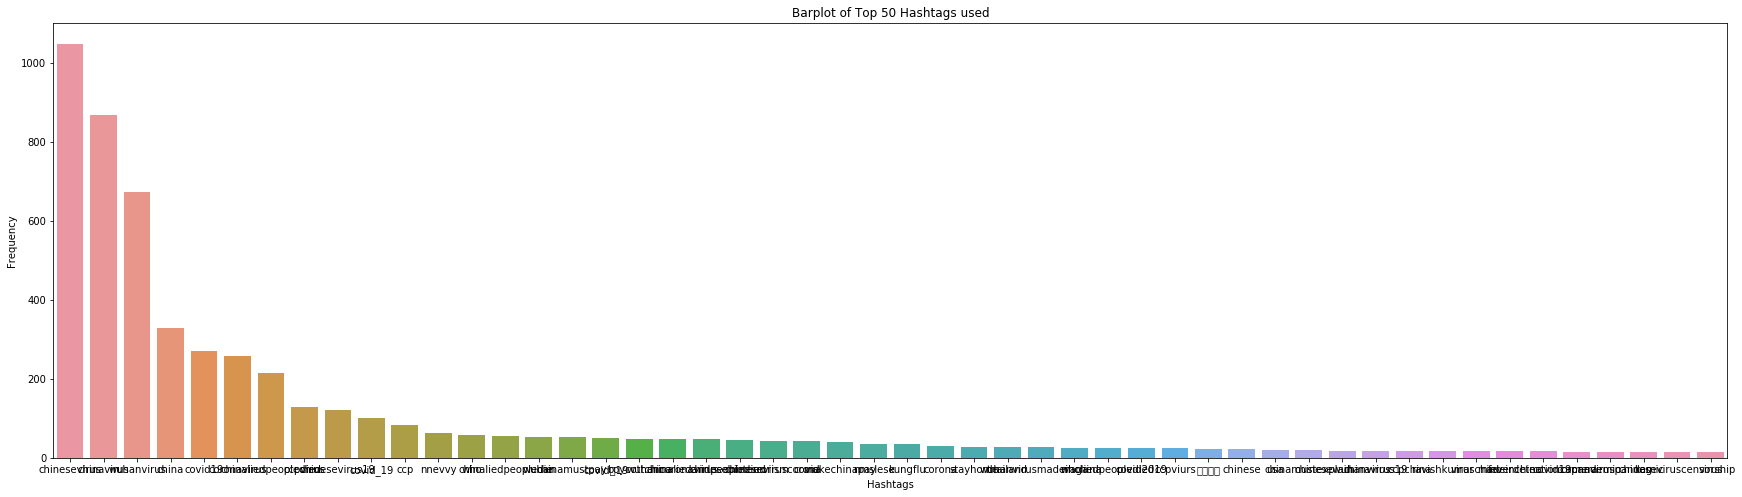

In [16]:
import seaborn as sns

# Define N to be the top number of hashtags
N = 50
top_hashtags = df_hashtag.groupby(['hashtags']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False).head(N)
print(top_hashtags)
# seaborn countplot on the top N hashtags
plt.figure(figsize=(30,8))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'hashtags', y = 'counts', data = top_hashtags)
plt.title('Barplot of Top ' + str(N) + ' Hashtags used')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.show()

In [20]:
def isNaN(num):
    return num != num

def get_full_name(x):
    if x is None or isNaN(x):
        return None
    else:
        return x['full_name']
data['place_full_name']=data['place'].apply(lambda x: get_full_name(x))

data[data['place_full_name'].apply(lambda x: x is not None)]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
115,2020-04-02 16:09:10+00:00,1245745097154551809,1245745097154551808,The Ram Mandir in Kolkata had categorically in...,False,"[0, 275]","{'hashtags': [{'text': 'ChineseVirus19', 'indi...","{'media': [{'id': 1245745093484507136, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,ram mandir kolkata categorically inform devote...,n.a,n.a,0.158,0.731,0.112,-0.0181,157,20,"Kolkata, India"
140,2020-04-02 16:31:16+00:00,1245750658806034432,1245750658806034432,"more than 450 people were found positive, who ...",False,"[0, 220]","{'hashtags': [{'text': 'COVID19Pandemic', 'ind...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",1.245751e+18,...,people find positive turn become threat entire...,n.a,n.a,0.439,0.370,0.190,-0.5719,80,11,"Dubai, United Arab Emirates"
169,2020-04-02 16:04:43+00:00,1245743974641545216,1245743974641545216,#cdanslair Antoine Flahault (épidémiologiste)\...,False,"[0, 225]","{'hashtags': [{'text': 'cdanslair', 'indices':...","{'media': [{'id': 1245743963748917248, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,antoine flahault épidémiologiste)\n-ce serait ...,n.a,n.a,0.119,0.881,0.000,-0.5423,178,26,"Marseille, France"
241,2020-04-03 01:35:11+00:00,1245887540369948674,1245887540369948672,@PDChina I’m the rest of world they’re picking...,False,"[9, 94]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",1.245881e+18,...,i’m rest world they’re pick funeral flower dead,n.a,n.a,0.531,0.469,0.000,-0.7783,47,8,"Stratford, London"
371,2020-04-05 11:41:29+00:00,1246764895963459585,1246764895963459584,@michaelxpettis @PaulGambles2 @SCMPNews perhap...,False,"[40, 312]","{'hashtags': [{'text': 'china', 'indices': [14...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",1.246681e+18,...,perhaps didn’t listen cuomo’s presser newyork/...,n.a,n.a,0.123,0.877,0.000,-0.4215,173,21,"San Francisco, CA"
627,2020-04-09 02:08:59+00:00,1248070373075292161,1248070373075292160,List of officers in-charge of Noida Hotspots. ...,False,"[0, 254]","{'hashtags': [{'text': 'CoronaCrisis', 'indice...","{'media': [{'id': 1248070355228471296, 'id_str...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,list officer in-charge noida hotspot,n.a,n.a,0.000,1.000,0.000,0.0000,36,5,"Noida, India"
649,2020-04-09 02:31:46+00:00,1248076106931916801,1248076106931916800,@ChinaSpox_India #ChinaVirus\n#WuhanVirusMadeI...,False,"[17, 93]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...",NaN,"<a href=""http://twitter.com/download/android"" ...",1.247778e+18,...,\n\n\n,n.a,n.a,0.000,0.000,0.000,0.0000,3,1,"Karnataka, India"
695,2020-04-09 03:21:41+00:00,1248088669522669571,1248088669522669568,ABC doing Chinas heavy lifting. Nice!! #Chines...,False,"[0, 87]","{'hashtags': [{'text': 'ChineseVirus', 'indice...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,abc china heavy lifting nice,n.a,n.a,0.000,0.588,0.412,0.4215,28,5,"Seymour, TN"
775,2020-04-10 03:04:55+00:00,1248446837025054720,1248446837025054720,You're welcome 😞\n.\n.\n.\n.\n.#pandemic #coro...,False,"[0, 212]","{'hashtags': [{'text': 'pandemic', 'indices': ...",NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,welcome \n.\n.\n.\n.\n,n.a,n.a,0.000,0.000,1.000,0.4588,17,2,"Muskegon Heights, MI"
1092,2020-04-16 10:58:57+00:00,1250740459346915329,1250740459346915328,"@bhak_sala @bhootnath No wonder ,\nSomeday the...",False,"[22, 135]","{'hashtags': [{'text': 'Oxygen', 'indices': [6...",NaN,"<a href=""http://twitter.com/download/android"" ...",1.250738e+18,...,wonder \nsomeday start import china fight \n\n,n.a,n.a,0.342,0.658,0.000,-0.3818,43,7,"Lucknow, India"


In [18]:
data[data['coordinates'].apply(lambda x: x is not None)]['coordinates']


775     {'type': 'Point', 'coordinates': [-86.2422, 43...
1724    {'type': 'Point', 'coordinates': [81.10528, 25...
Name: coordinates, dtype: object